**Downloading Kaggle Data Sets Directly into Colab**

Install the kaggle python library

In [1]:
! pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Mount the Google drive so you can store your kaggle API credentials for future use

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Make a directory for kaggle at the temporary instance location on Colab drive.

Download your kaggle API key (.json file). You can do this by going to your kaggle account page and clicking 'Create new API token' under the API section.

In [3]:
! mkdir ~/.kaggle

Upload the json file to Google Drive and then copy to the temporary location.

In [4]:
!cp /content/drive/MyDrive/anime_faces/kaggle.json ~/.kaggle/kaggle.json

Change the file permissions to read/write to the owner only

In [5]:
! chmod 600 ~/.kaggle/kaggle.json

**Download competition data**

If you get 403 Forbidden error, you need to click 'Late Submission' on the Kaggle page for that competition.

In [6]:
! kaggle datasets download -d soumikrakshit/anime-faces

 96% 423M/441M [00:03<00:00, 139MB/s]
100% 441M/441M [00:03<00:00, 116MB/s]


In [7]:
!mkdir faces
!mv anime-faces.zip faces

In [8]:
%cd faces

/content/faces


In [9]:
%ls

anime-faces.zip


Unzip, in case the downloaded file is zipped. Refresh the files on the left hand side to update the view. 

In [10]:
! unzip anime-faces.zip

Se han truncado las últimas 5000 líneas del flujo de salida.
  inflating: data/data/5499.png      
  inflating: data/data/55.png        
  inflating: data/data/550.png       
  inflating: data/data/5500.png      
  inflating: data/data/5501.png      
  inflating: data/data/5502.png      
  inflating: data/data/5503.png      
  inflating: data/data/5504.png      
  inflating: data/data/5505.png      
  inflating: data/data/5506.png      
  inflating: data/data/5507.png      
  inflating: data/data/5508.png      
  inflating: data/data/5509.png      
  inflating: data/data/551.png       
  inflating: data/data/5510.png      
  inflating: data/data/5511.png      
  inflating: data/data/5512.png      
  inflating: data/data/5513.png      
  inflating: data/data/5514.png      
  inflating: data/data/5515.png      
  inflating: data/data/5516.png      
  inflating: data/data/5517.png      
  inflating: data/data/5518.png      
  inflating: data/data/5519.png      
  inflating: data/data/552.

In [11]:
%cd ../

/content


In [12]:
!ls

drive  faces  sample_data


Importing Libraries

In [13]:
import tensorflow as tf

import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time
from IPython import display
from glob import glob

Setting the Weight, Height and Channels of the Avatar Images

In [14]:
IMG_H = 64 
IMG_W = 64 
IMG_C = 3

In [15]:
BUFFER_SIZE = 25551
BATCH_SIZE = 128

In [16]:
def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.io.decode_jpeg(img)
    img = tf.image.resize_with_crop_or_pad(img, IMG_H, IMG_W)
    img = tf.cast(img, tf.float32)
    img = (img - 127.5) / 127.5
    return img

In [17]:
def tf_dataset(images_path, batch_size):
    dataset = tf.data.Dataset.from_tensor_slices(images_path)
    dataset = dataset.shuffle(BUFFER_SIZE)
    dataset = dataset.map(load_image)
    dataset = dataset.batch(batch_size)
    return dataset

In [18]:
images_path = glob("/content/faces/data/data/*")

train_dataset = tf_dataset(images_path=images_path, batch_size=BATCH_SIZE)

Generator Model

In [33]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(8*8*128, input_shape=(128,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((8, 8, 128)))

    assert model.output_shape == (None, 8, 8, 128)

    model.add(layers.Conv2DTranspose(32, kernel_size=(4, 4), strides=(2, 2), padding='same'))
    assert model.output_shape == (None, 16, 16, 32)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, kernel_size=(4, 4), strides=(2, 2), padding='same'))
    assert model.output_shape == (None, 32, 32, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(128, kernel_size=(4, 4), strides=(2, 2), padding='same'))
    assert model.output_shape == (None, 64, 64, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2D(3, kernel_size=(5, 5), padding='same', activation='tanh'))

    return model

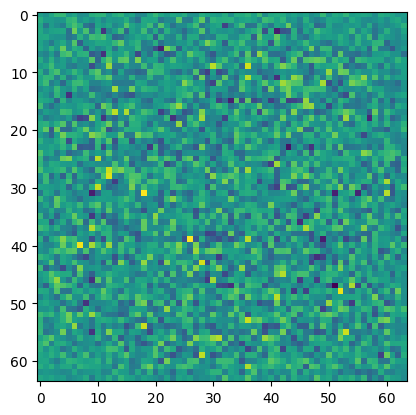

In [34]:
generator = make_generator_model()

noise = tf.random.normal([1, 128])

generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0])

Discriminator Model

In [35]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[64, 64, 3]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

In [36]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print (decision)

tf.Tensor([[0.0022924]], shape=(1, 1), dtype=float32)


In [37]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [38]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [39]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [40]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [41]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [42]:
EPOCHS = 200
noise_dim = 128
num_examples_to_generate = 16

seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [43]:
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [44]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)

    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)

    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed)

In [45]:
def generate_and_save_images(model, epoch, test_input):
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4, 4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap="viridis")
      plt.axis('off')

  plt.savefig('./epochs_imgs/image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

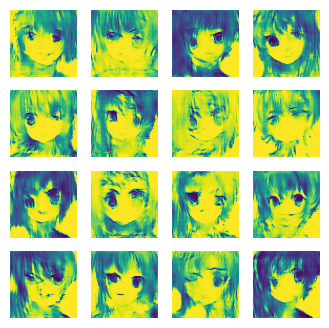

In [46]:
train(train_dataset, EPOCHS)  